<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260128_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (지수항 통일 및 Deterministic Noise)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.001):
        self.L, self.nu = L, nu

    # [공통] 감쇠 함수 (신호와 노이즈 비율 유지)
    def get_decay(self, t):
        k = 1
        return np.exp(-2 * (k * np.pi)**2 * self.nu * t)

    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = self.get_decay(t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * (decay**2)
        return u, v, p

    def get_unphysical_noise(self, X, Y, t):
        # 결정론적 노이즈 (함수 형태이므로 임의의 t에 대해 생성 가능)
        decay = self.get_decay(t)
        noise_scale = 0.1 * self.get_decay(t)
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = (decay**2) * 0.1 * 0.25 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n

    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)

        # LF = HF + Noise
        u_lf, v_lf, p_lf = u_hf + u_n, v_hf + v_n, p_hf + p_n

        return X, Y, u_lf, v_lf, p_lf, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (입력에 LF 포함)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max_train = 10.0
T_scale = 13.0 # 정규화 상수
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max_train, 11) # 0, 1, ..., 10

# 리스트 초기화
x_list, y_list, t_list = [], [], []
u_lf_list, v_lf_list, p_lf_list = [], [], [] # [NEW] 입력으로 사용될 LF
u_hf_list, v_hf_list, p_hf_list = [], [], [] # [NEW] 타겟으로 사용될 HF

print("Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...")
for t in train_times:
    X, Y, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t)

    x_list.append(X.flatten())
    y_list.append(Y.flatten())
    t_list.append(np.full(X.size, t))

    # LF를 입력(Feature)으로 저장
    u_lf_list.append(u_l.flatten())
    v_lf_list.append(v_l.flatten())
    p_lf_list.append(p_l.flatten())

    # HF를 정답(Target)으로 저장
    u_hf_list.append(u_h.flatten())
    v_hf_list.append(v_h.flatten())
    p_hf_list.append(p_h.flatten())

# 텐서 변환
# 1. 좌표 입력
x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_scale, dtype=torch.float32).view(-1, 1).to(device)

# 2. LF 유동장 입력 (Input Features)
u_lf_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_lf_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_lf_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. HF 유동장 타겟 (Labels)
u_hf_train = torch.tensor(np.concatenate(u_hf_list), dtype=torch.float32).view(-1, 1).to(device)
v_hf_train = torch.tensor(np.concatenate(v_hf_list), dtype=torch.float32).view(-1, 1).to(device)
p_hf_train = torch.tensor(np.concatenate(p_hf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (입력 차원 증가: 3 -> 6)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=4.0):
        super().__init__()
        # 좌표(x,y,t)에 대해서만 Fourier Feature를 적용하는 것이 일반적이나,
        # 여기서는 전체 입력 6개에 대해 적용하거나, 좌표만 적용 후 LF는 concat할 수 있습니다.
        # 간단하고 강력한 성능을 위해 6개 채널 모두 임베딩하거나,
        # 좌표 3개만 임베딩하고 나머지는 그냥 붙이는 방식을 씁니다.
        # 여기서는 "좌표(3) 임베딩 + LF(3) 원본" 구조를 추천합니다. (물리적 위치 정보 강조)
        self.register_buffer("B", torch.randn(3, 128) * scale) # 좌표용 B

    def forward(self, coords, fields):
        # coords: x, y, t
        # fields: u_lf, v_lf, p_lf
        x_proj = 2 * np.pi * coords @ self.B
        emb = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
        # 임베딩된 좌표 특징과 원본 LF 값을 결합
        return torch.cat([emb, fields], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3) # 좌표 3개 임베딩
        # 입력 크기: (128*2) + 3(LF fields) = 259
        self.net = nn.Sequential(
            nn.Linear(256 + 3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3) # Output: HF correction
        )
    def forward(self, x, y, t, u_lf, v_lf, p_lf):
        coords = torch.cat([x, y, t], dim=1)
        fields = torch.cat([u_lf, v_lf, p_lf], dim=1)
        return self.net(self.embedding(coords, fields))

# 4. Phase 0: Warm-up (Supervised Learning: LF input -> HF output)
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("\n--- Phase 0: Warm-up (Learning to map LF to HF) ---")
for epoch in range(1501):
    optimizer.zero_grad()
    # 입력으로 LF 데이터도 함께 줍니다.
    pred = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)

    # 타겟은 HF 데이터입니다.
    loss = torch.mean((pred[:,0:1]-u_hf_train)**2 + \
                      (pred[:,1:2]-v_hf_train)**2 + \
                      (pred[:,2:3]-p_hf_train)**2)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005:
      print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
      break

torch.save(model.state_dict(), "warmup_model.pth")

Generating Data: Inputs (x,y,t, LF) -> Targets (HF)...

--- Phase 0: Warm-up (Learning to map LF to HF) ---
Epoch 0 | Loss: 0.158489
Epoch 50 | Loss: 0.023897
Epoch 100 | Loss: 0.009290
Epoch 150 | Loss: 0.001531
Epoch 200 | Loss: 0.000567
Epoch 210 | Loss: 0.000496



--- Phase 1: Physics Training with Focused Sampling ---
Ep     0 | Total: 0.000367 | Data: 0.000489 | PDE: 0.541632
         > Last 500 eps: 0.55s | Total: 0.0m
Ep   500 | Total: 0.002036 | Data: 0.000463 | PDE: 0.010135
         > Last 500 eps: 434.55s | Total: 7.3m
Ep  1000 | Total: 0.000894 | Data: 0.000268 | PDE: 0.002079
         > Last 500 eps: 433.30s | Total: 14.5m
Ep  1500 | Total: 0.000564 | Data: 0.000231 | PDE: 0.000781
         > Last 500 eps: 434.13s | Total: 21.7m
Ep  2000 | Total: 0.000432 | Data: 0.000223 | PDE: 0.000396
         > Last 500 eps: 434.52s | Total: 29.0m
Ep  2500 | Total: 0.000364 | Data: 0.000223 | PDE: 0.000236
         > Last 500 eps: 434.10s | Total: 36.2m
Ep  3000 | Total: 0.000327 | Data: 0.000224 | PDE: 0.000159
         > Last 500 eps: 434.52s | Total: 43.5m

--- Phase 2: Refinement (L-BFGS) ---
L-BFGS Complete. Duration: 1783.73 sec

[Interpolation (t=1.25)] Time t=1.25
Input MSE (LF vs HF): 0.00233227
Output MSE (Pred vs HF): 0.00012255
Improve

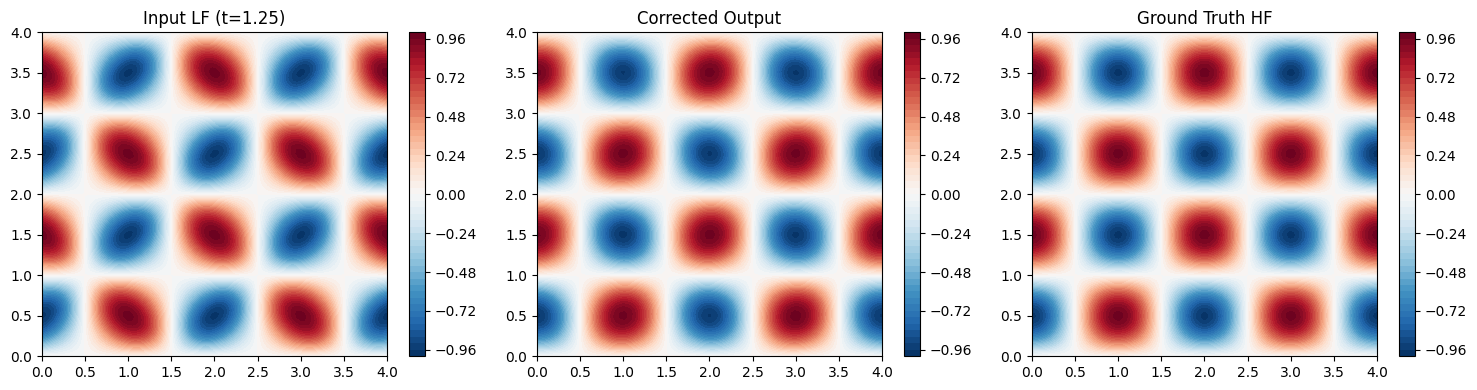


[Interpolation (t=2.5)] Time t=2.5
Input MSE (LF vs HF): 0.00221997
Output MSE (Pred vs HF): 0.00012727
Improvement: 94.27%


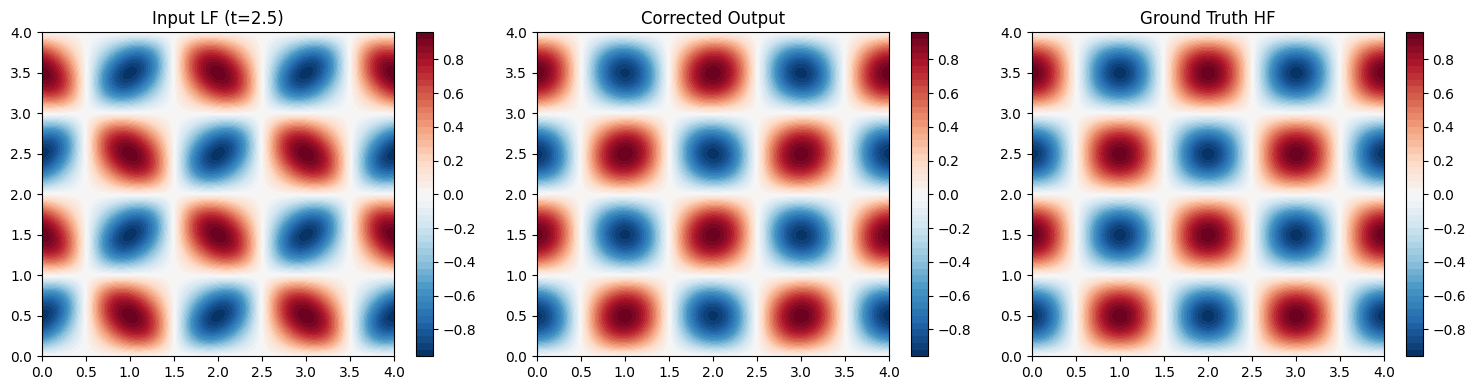


[Interpolation (t=7.3)] Time t=7.3
Input MSE (LF vs HF): 0.00183675
Output MSE (Pred vs HF): 0.00005734
Improvement: 96.88%


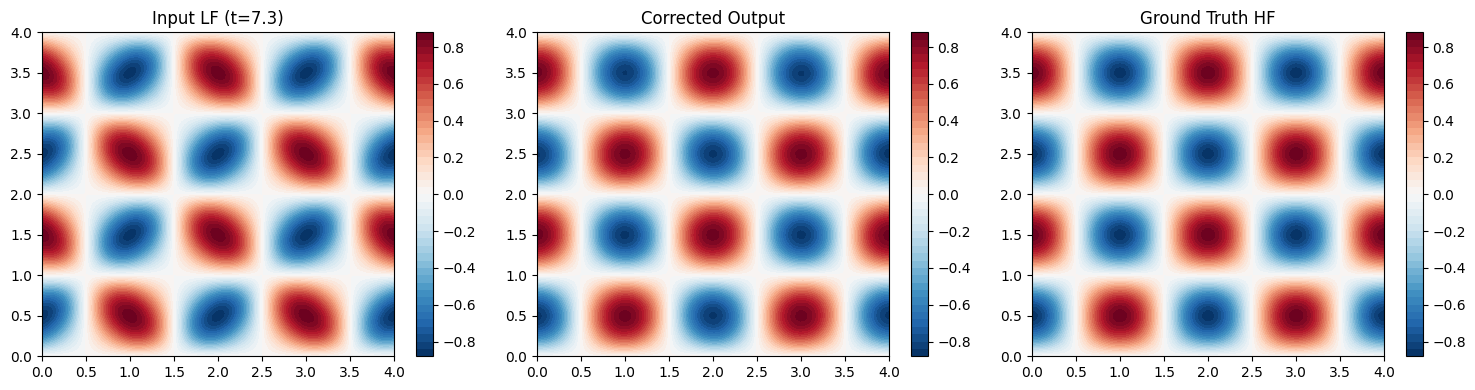


[Interpolation (t=9.5)] Time t=9.5
Input MSE (LF vs HF): 0.00168395
Output MSE (Pred vs HF): 0.00004558
Improvement: 97.29%


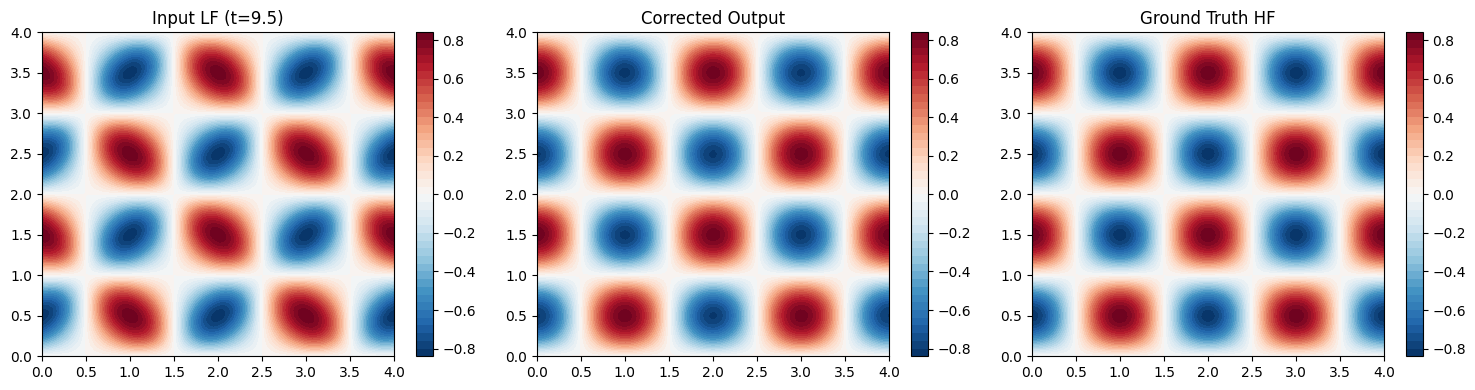


[Extrapolation (t=11.5)] Time t=11.5
Input MSE (LF vs HF): 0.00155611
Output MSE (Pred vs HF): 0.00005829
Improvement: 96.25%


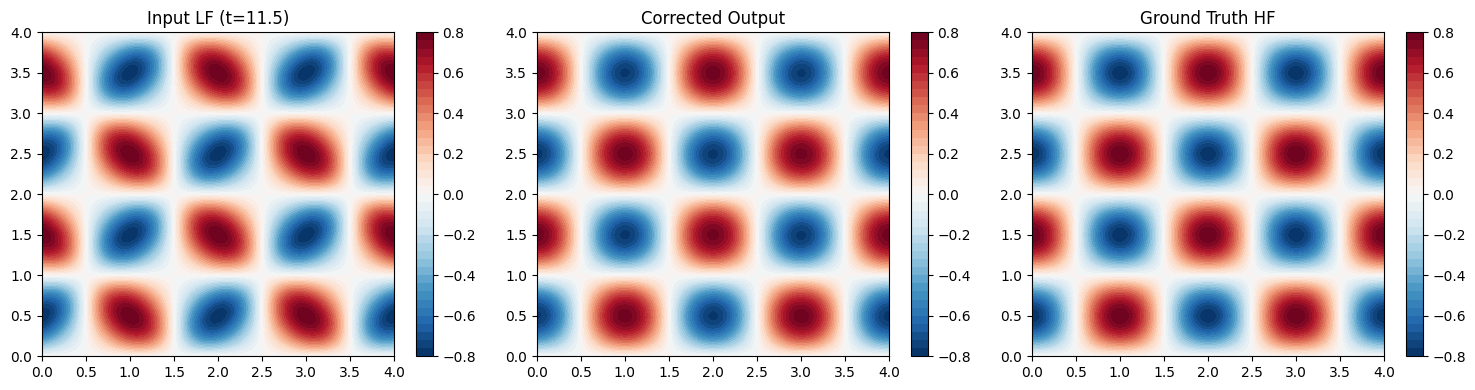


[Extrapolation (t=13.0)] Time t=13.0
Input MSE (LF vs HF): 0.00146663
Output MSE (Pred vs HF): 0.00007633
Improvement: 94.80%


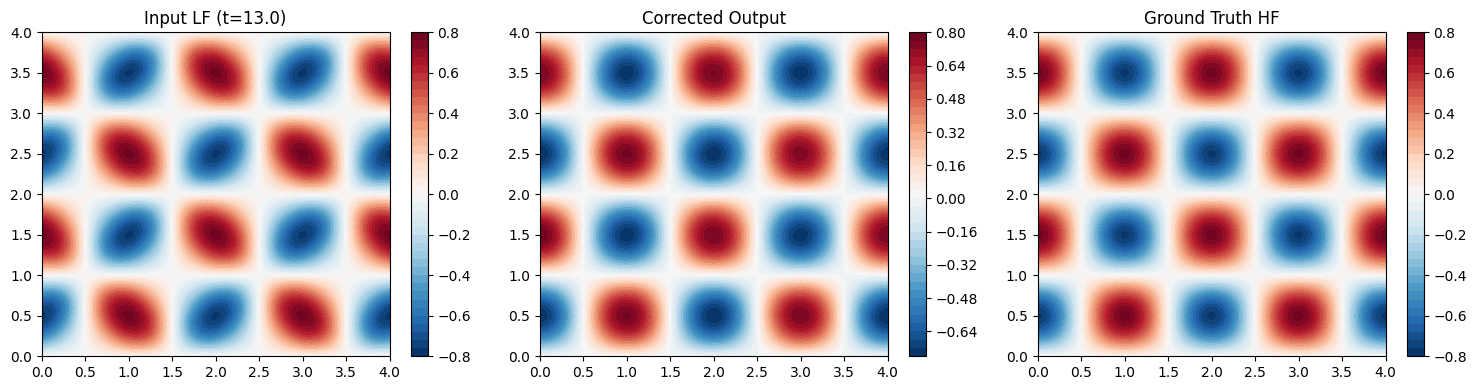


[Extrapolation (t=15.0)] Time t=15.0
Input MSE (LF vs HF): 0.00135529
Output MSE (Pred vs HF): 0.00013247
Improvement: 90.23%


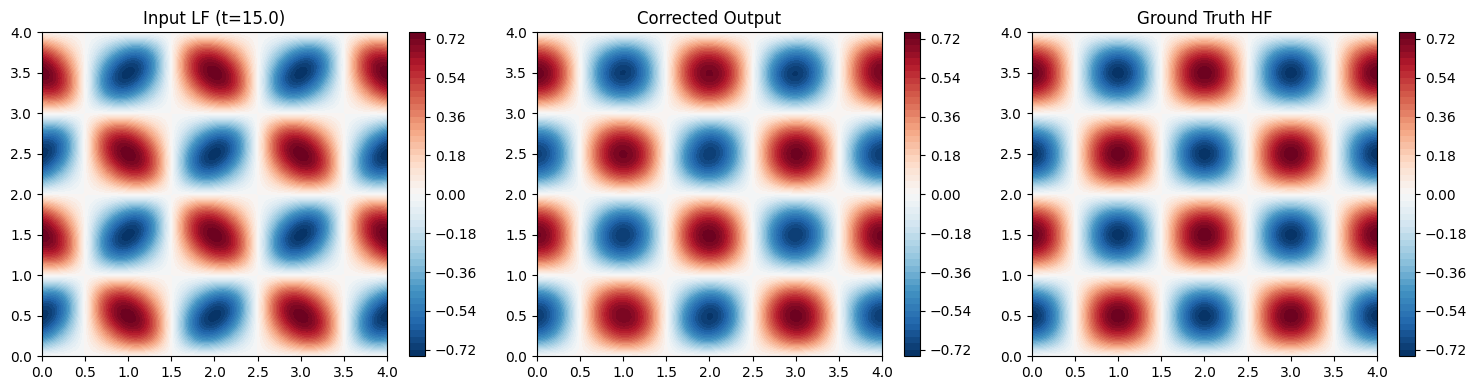


[Extrapolation (t=20.0)] Time t=20.0
Input MSE (LF vs HF): 0.00111251
Output MSE (Pred vs HF): 0.00015287
Improvement: 86.26%


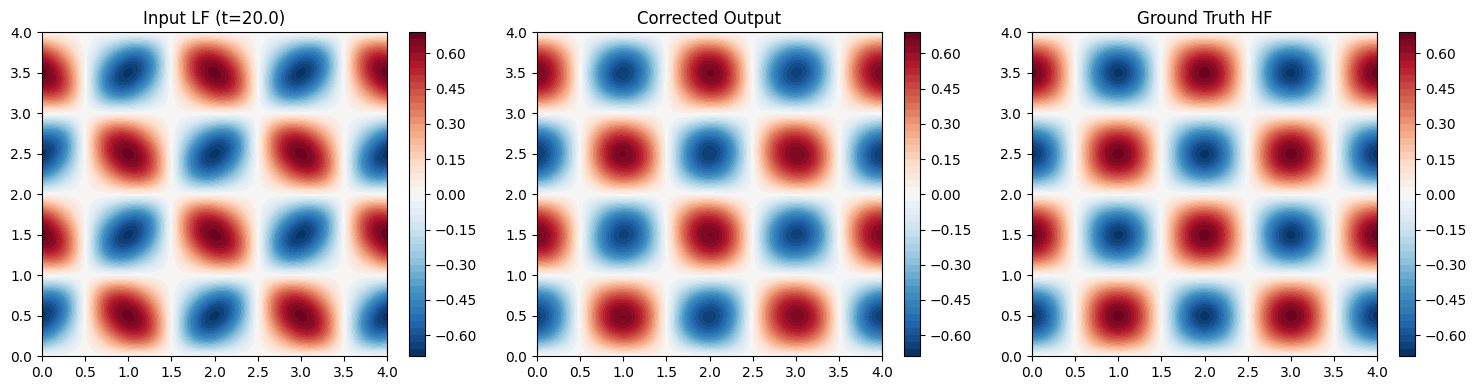


[Extrapolation (t=25.0)] Time t=25.0
Input MSE (LF vs HF): 0.00091323
Output MSE (Pred vs HF): 0.00017577
Improvement: 80.75%


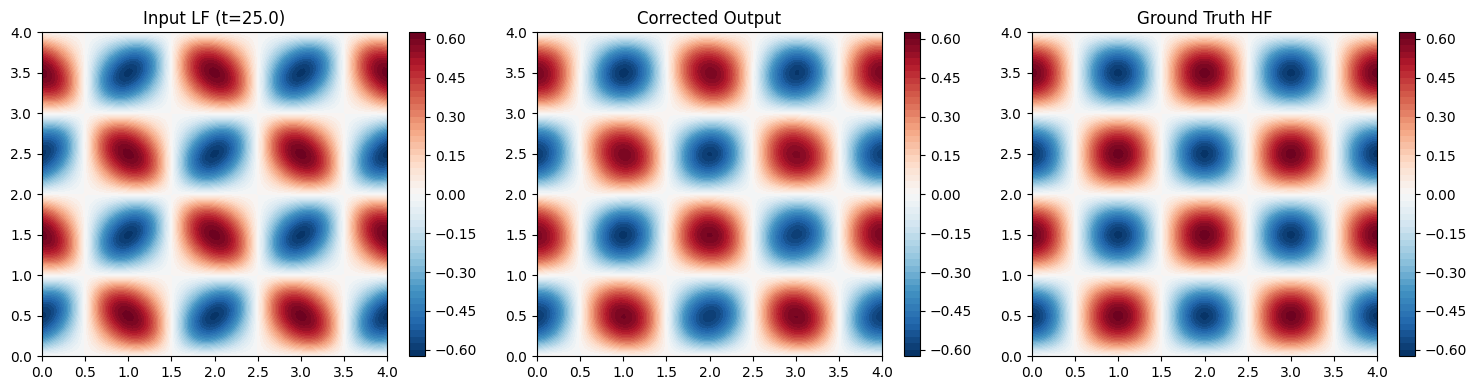


[Extrapolation (t=30.0)] Time t=30.0
Input MSE (LF vs HF): 0.00074964
Output MSE (Pred vs HF): 0.00017965
Improvement: 76.04%


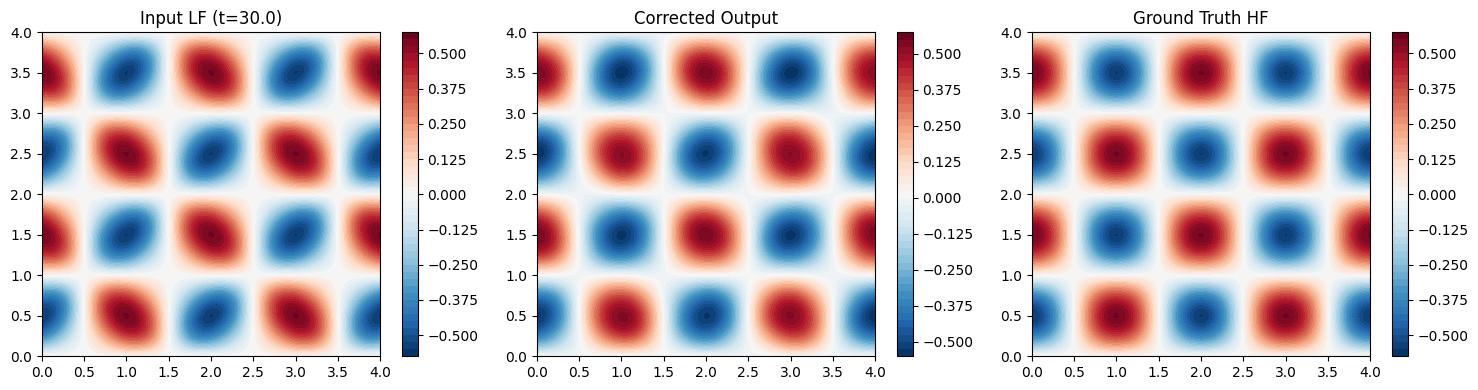

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 파라미터 유지
L_val = 4.0
nu_val = 0.001
T_scale = 13.0
T_pred_max = 13.0
T_train_max = 10.0 # 학습 데이터의 한계 시점

generator = FluidGenerator(L=L_val, nu=nu_val)

# 1. 물리 식 정의 (동일)
def get_pde_loss(model, x, y, t, u_lf_in, v_lf_in, p_lf_in, nu, L, T_scale):
    out = model(x, y, t, u_lf_in, v_lf_in, p_lf_in)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T_scale
    v_t = grad(v, t) / T_scale
    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y = u_x_raw/L, u_y_raw/L
    v_x, v_y = v_x_raw/L, v_y_raw/L
    p_x, p_y = p_x_raw/L, p_y_raw/L

    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# 2. 학습 준비
clear_memory()
model = PINN().to(device)
model.load_state_dict(torch.load("warmup_model.pth"))

# PDE용 그리드 설정 (기본 틀)
nt_p, nx_p, ny_p = 30, 40, 40 # 샘플 개수 살짝 조정
t_g = torch.linspace(0, T_pred_max/T_scale, nt_p, device=device)
x_g = torch.linspace(0, 1, nx_p, device=device)
y_g = torch.linspace(0, 1, ny_p, device=device)
# 메쉬그리드는 shape 참조용으로만 사용
T_m, X_m, Y_m = torch.meshgrid(t_g, x_g, y_g, indexing='ij')

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# ==========================================
# 3. Phase 1: Physics Training (Focus Sampling)
# ==========================================
print("\n--- Phase 1: Physics Training with Focused Sampling ---")

phase1_start_time = time.time()
block_start_time = time.time()

# [전략] 배치의 절반은 0~10초(학습영역), 절반은 10~13초(외삽영역)에서 샘플링
half_size = T_m.numel() // 2

for epoch in range(3001):
    if epoch == 4000:
        for pg in optimizer.param_groups: pg['lr'] = 5e-5

    optimizer.zero_grad()

    # --- [수정된 샘플링 로직 시작] ---
    # 1. 학습 구간 (0 ~ 10초) 샘플링
    t_1 = torch.rand(half_size, 1, device=device) * (T_train_max / T_scale)

    # 2. 외삽 구간 (10 ~ 13초) 샘플링 -> 모델에게 "여기를 잘 봐!"라고 강제
    t_2 = torch.rand(half_size, 1, device=device) * ((T_pred_max - T_train_max) / T_scale) + (T_train_max / T_scale)

    # 3. 합치기
    t_rand = torch.cat([t_1, t_2], dim=0)

    # x, y는 전체 구간(0~1)에서 랜덤
    x_rand = torch.rand(half_size * 2, 1, device=device)
    y_rand = torch.rand(half_size * 2, 1, device=device)

    # 실제 물리 좌표로 변환 (LF 생성용)
    x_phys_np = x_rand.cpu().numpy() * L_val
    y_phys_np = y_rand.cpu().numpy() * L_val
    t_phys_np = t_rand.cpu().numpy() * T_scale

    # LF 값 생성
    u_h_np, v_h_np, p_h_np = generator.get_tgv_solution(x_phys_np, y_phys_np, t_phys_np)
    u_n_np, v_n_np, p_n_np = generator.get_unphysical_noise(x_phys_np, y_phys_np, t_phys_np)

    u_lf_in = torch.tensor(u_h_np + u_n_np, dtype=torch.float32).to(device)
    v_lf_in = torch.tensor(v_h_np + v_n_np, dtype=torch.float32).to(device)
    p_lf_in = torch.tensor(p_h_np + p_n_np, dtype=torch.float32).to(device)

    # Gradient 추적 설정
    x_p = x_rand.requires_grad_(True)
    y_p = y_rand.requires_grad_(True)
    t_p = t_rand.requires_grad_(True)
    # --- [수정된 샘플링 로직 끝] ---

    # 1. Data Loss
    pred_data = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    l_data = torch.mean((pred_data[:,0:1]-u_hf_train)**2 + \
                        (pred_data[:,1:2]-v_hf_train)**2 + \
                        (pred_data[:,2:3]-p_hf_train)**2)

    # 2. PDE Loss (집중 샘플링된 점들)
    l_mass, l_mom = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)

    pde_w = min(1.0 * (epoch/3000), 1.0)
    total_loss = 0.75 * l_data + pde_w * (l_mass + l_mom)

    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        current_time = time.time()
        block_duration = current_time - block_start_time
        total_elapsed = current_time - phase1_start_time
        print(f"Ep {epoch:5d} | Total: {total_loss.item():.6f} | Data: {l_data.item():.6f} | PDE: {l_mass.item()+l_mom.item():.6f}")
        print(f"         > Last 500 eps: {block_duration:.2f}s | Total: {total_elapsed/60:.1f}m")
        block_start_time = time.time()

# ==========================================
# 4. Phase 2: L-BFGS
# ==========================================
print("\n--- Phase 2: Refinement (L-BFGS) ---")
lbfgs = optim.LBFGS(model.parameters(), max_iter=2000, history_size=50, line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    out = model(x_train, y_train, t_train, u_lf_train, v_lf_train, p_lf_train)
    ld = torch.mean((out[:,0:1]-u_hf_train)**2 + (out[:,1:2]-v_hf_train)**2 + (out[:,2:3]-p_hf_train)**2)
    lm, lmo = get_pde_loss(model, x_p, y_p, t_p, u_lf_in, v_lf_in, p_lf_in, nu_val, L_val, T_scale)
    loss = 0.75 * ld + 1.0 * (lm + lmo) # PDE 가중치 1.0 유지
    if loss.requires_grad: loss.backward()
    return loss

lbfgs_start_time = time.time()
lbfgs.step(closure)
lbfgs_end_time = time.time()
print(f"L-BFGS Complete. Duration: {lbfgs_end_time - lbfgs_start_time:.2f} sec")

# ==========================================
# 5. 결과 검증
# ==========================================
def test_correction(test_t, scenario_name):
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)

    print(f"\n[{scenario_name}] Time t={test_t}")
    print(f"Input MSE (LF vs HF): {mse_lf:.8f}")
    print(f"Output MSE (Pred vs HF): {mse_pinn:.8f}")
    if mse_lf > 1e-12:
        print(f"Improvement: {(mse_lf - mse_pinn)/mse_lf * 100:.2f}%")
    else:
        print("Improvement: N/A")

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1); plt.title(f"Input LF (t={test_t})"); plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 2); plt.title("Corrected Output"); plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r'); plt.colorbar()
    plt.subplot(1, 3, 3); plt.title("Ground Truth HF"); plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r'); plt.colorbar()
    plt.tight_layout(); plt.show()

test_correction(1.25, "Interpolation (t=1.25)")
test_correction(2.5, "Interpolation (t=2.5)")
test_correction(7.3, "Interpolation (t=7.3)")
test_correction(9.5, "Interpolation (t=9.5)")
test_correction(11.5, "Extrapolation (t=11.5)")
test_correction(13.0, "Extrapolation (t=13.0)")
test_correction(15.0, "Extrapolation (t=15.0)")
test_correction(20.0, "Extrapolation (t=20.0)")
test_correction(25.0, "Extrapolation (t=25.0)")
test_correction(30.0, "Extrapolation (t=30.0)")

In [ ]:
import os

# 1. 저장할 폴더 생성 (없으면 생성)
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created.")

# 2. 이미지를 저장하는 함수 정의
def save_visualization(test_t, scenario_name):
    # 데이터 생성
    X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, test_t)

    # 텐서 변환
    x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
    t_in = torch.tensor(np.full(x_in.shape, test_t/T_scale), dtype=torch.float32).view(-1, 1).to(device)

    u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
    p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
        u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

    # 오차 계산
    mse_lf = np.mean((u_l - u_h)**2)
    mse_pinn = np.mean((u_pred - u_h)**2)
    improvement = "N/A"
    if mse_lf > 1e-12:
        improvement = f"{(mse_lf - mse_pinn)/mse_lf * 100:.2f}%"

    # 시각화 (이미지 생성)
    plt.figure(figsize=(15, 4))

    # Input LF
    plt.subplot(1, 3, 1)
    plt.title(f"Input LF (t={test_t})")
    plt.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r')
    plt.colorbar()

    # Corrected Output
    plt.subplot(1, 3, 2)
    plt.title(f"Model Prediction\n(Improvement: {improvement})")
    plt.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r')
    plt.colorbar()

    # Ground Truth HF
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth HF")
    plt.contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r')
    plt.colorbar()

    plt.tight_layout()

    # 파일 저장
    filename = f"result_t_{test_t:.2f}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=150) # 해상도 150 dpi로 저장
    plt.close() # 메모리 해제를 위해 닫기

    print(f"Saved: {filepath} | {scenario_name}")

# 3. 저장할 시간대 리스트 정의 및 실행
test_times = [
    (1.25, "Interpolation"),
    (2.5, "Interpolation"),
    (7.3, "Interpolation"),
    (9.5, "Interpolation"),
    (11.5, "Extrapolation"),
    (13.0, "Extrapolation"),
    (15.0, "Extrapolation"),
    (20.0, "Extrapolation"),
    (25.0, "Extrapolation"),
    (30.0, "Extrapolation")
]

print("--- Saving Prediction Images ---")
for t_val, desc in test_times:
    save_visualization(t_val, desc)

print("\nDone! Images are saved in the 'results' folder.")

# 4. (선택사항) 폴더를 압축해서 다운로드 받기 쉽게 만들기
import shutil
shutil.make_archive('results_archive', 'zip', save_dir)
print("Zip file created: results_archive.zip")

Directory 'results' created.
--- Saving Prediction Images ---
Saved: results/result_t_1.25.png | Interpolation
Saved: results/result_t_2.50.png | Interpolation
Saved: results/result_t_7.30.png | Interpolation
Saved: results/result_t_9.50.png | Interpolation
Saved: results/result_t_11.50.png | Extrapolation
Saved: results/result_t_13.00.png | Extrapolation
Saved: results/result_t_15.00.png | Extrapolation
Saved: results/result_t_20.00.png | Extrapolation
Saved: results/result_t_25.00.png | Extrapolation
Saved: results/result_t_30.00.png | Extrapolation

Done! Images are saved in the 'results' folder.
Zip file created: results_archive.zip


Calculating performance metrics over time (0s ~ 30s)...
Data calculation complete. Generatig graphs...
1. MSE Graph saved to: results/mse_log_scale.png
2. Improvement Graph saved to: results/improvement_trend.png


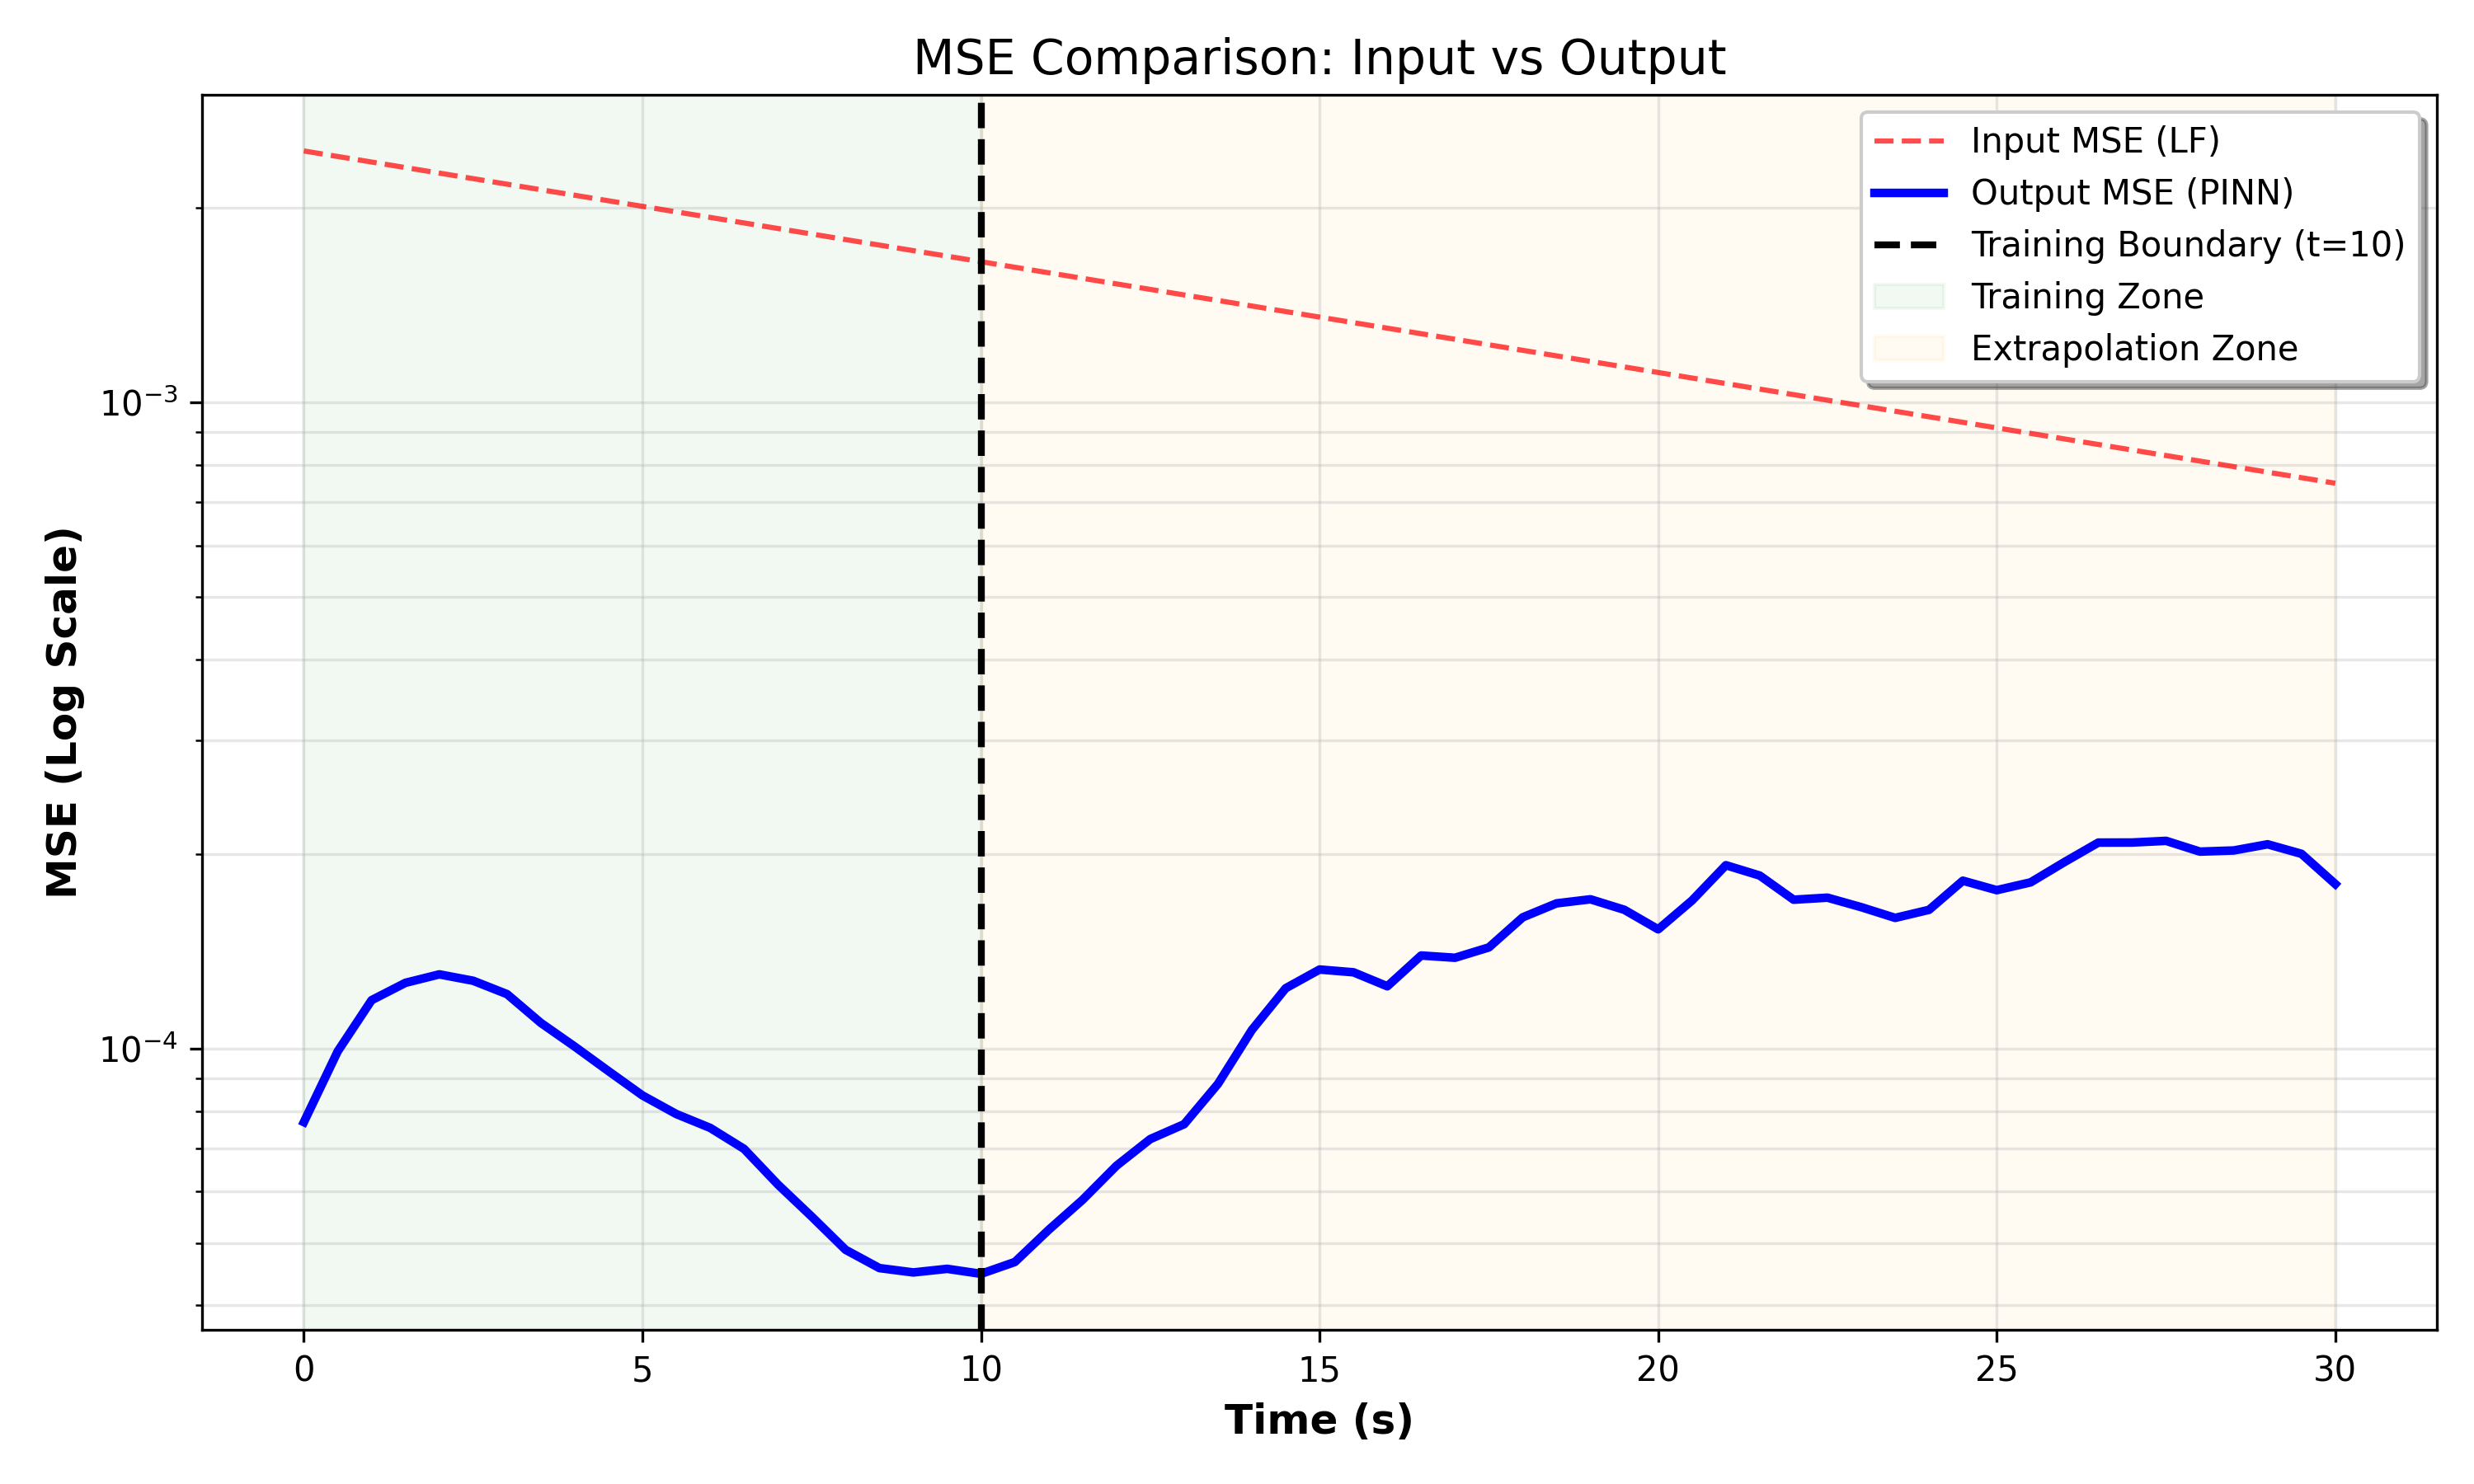

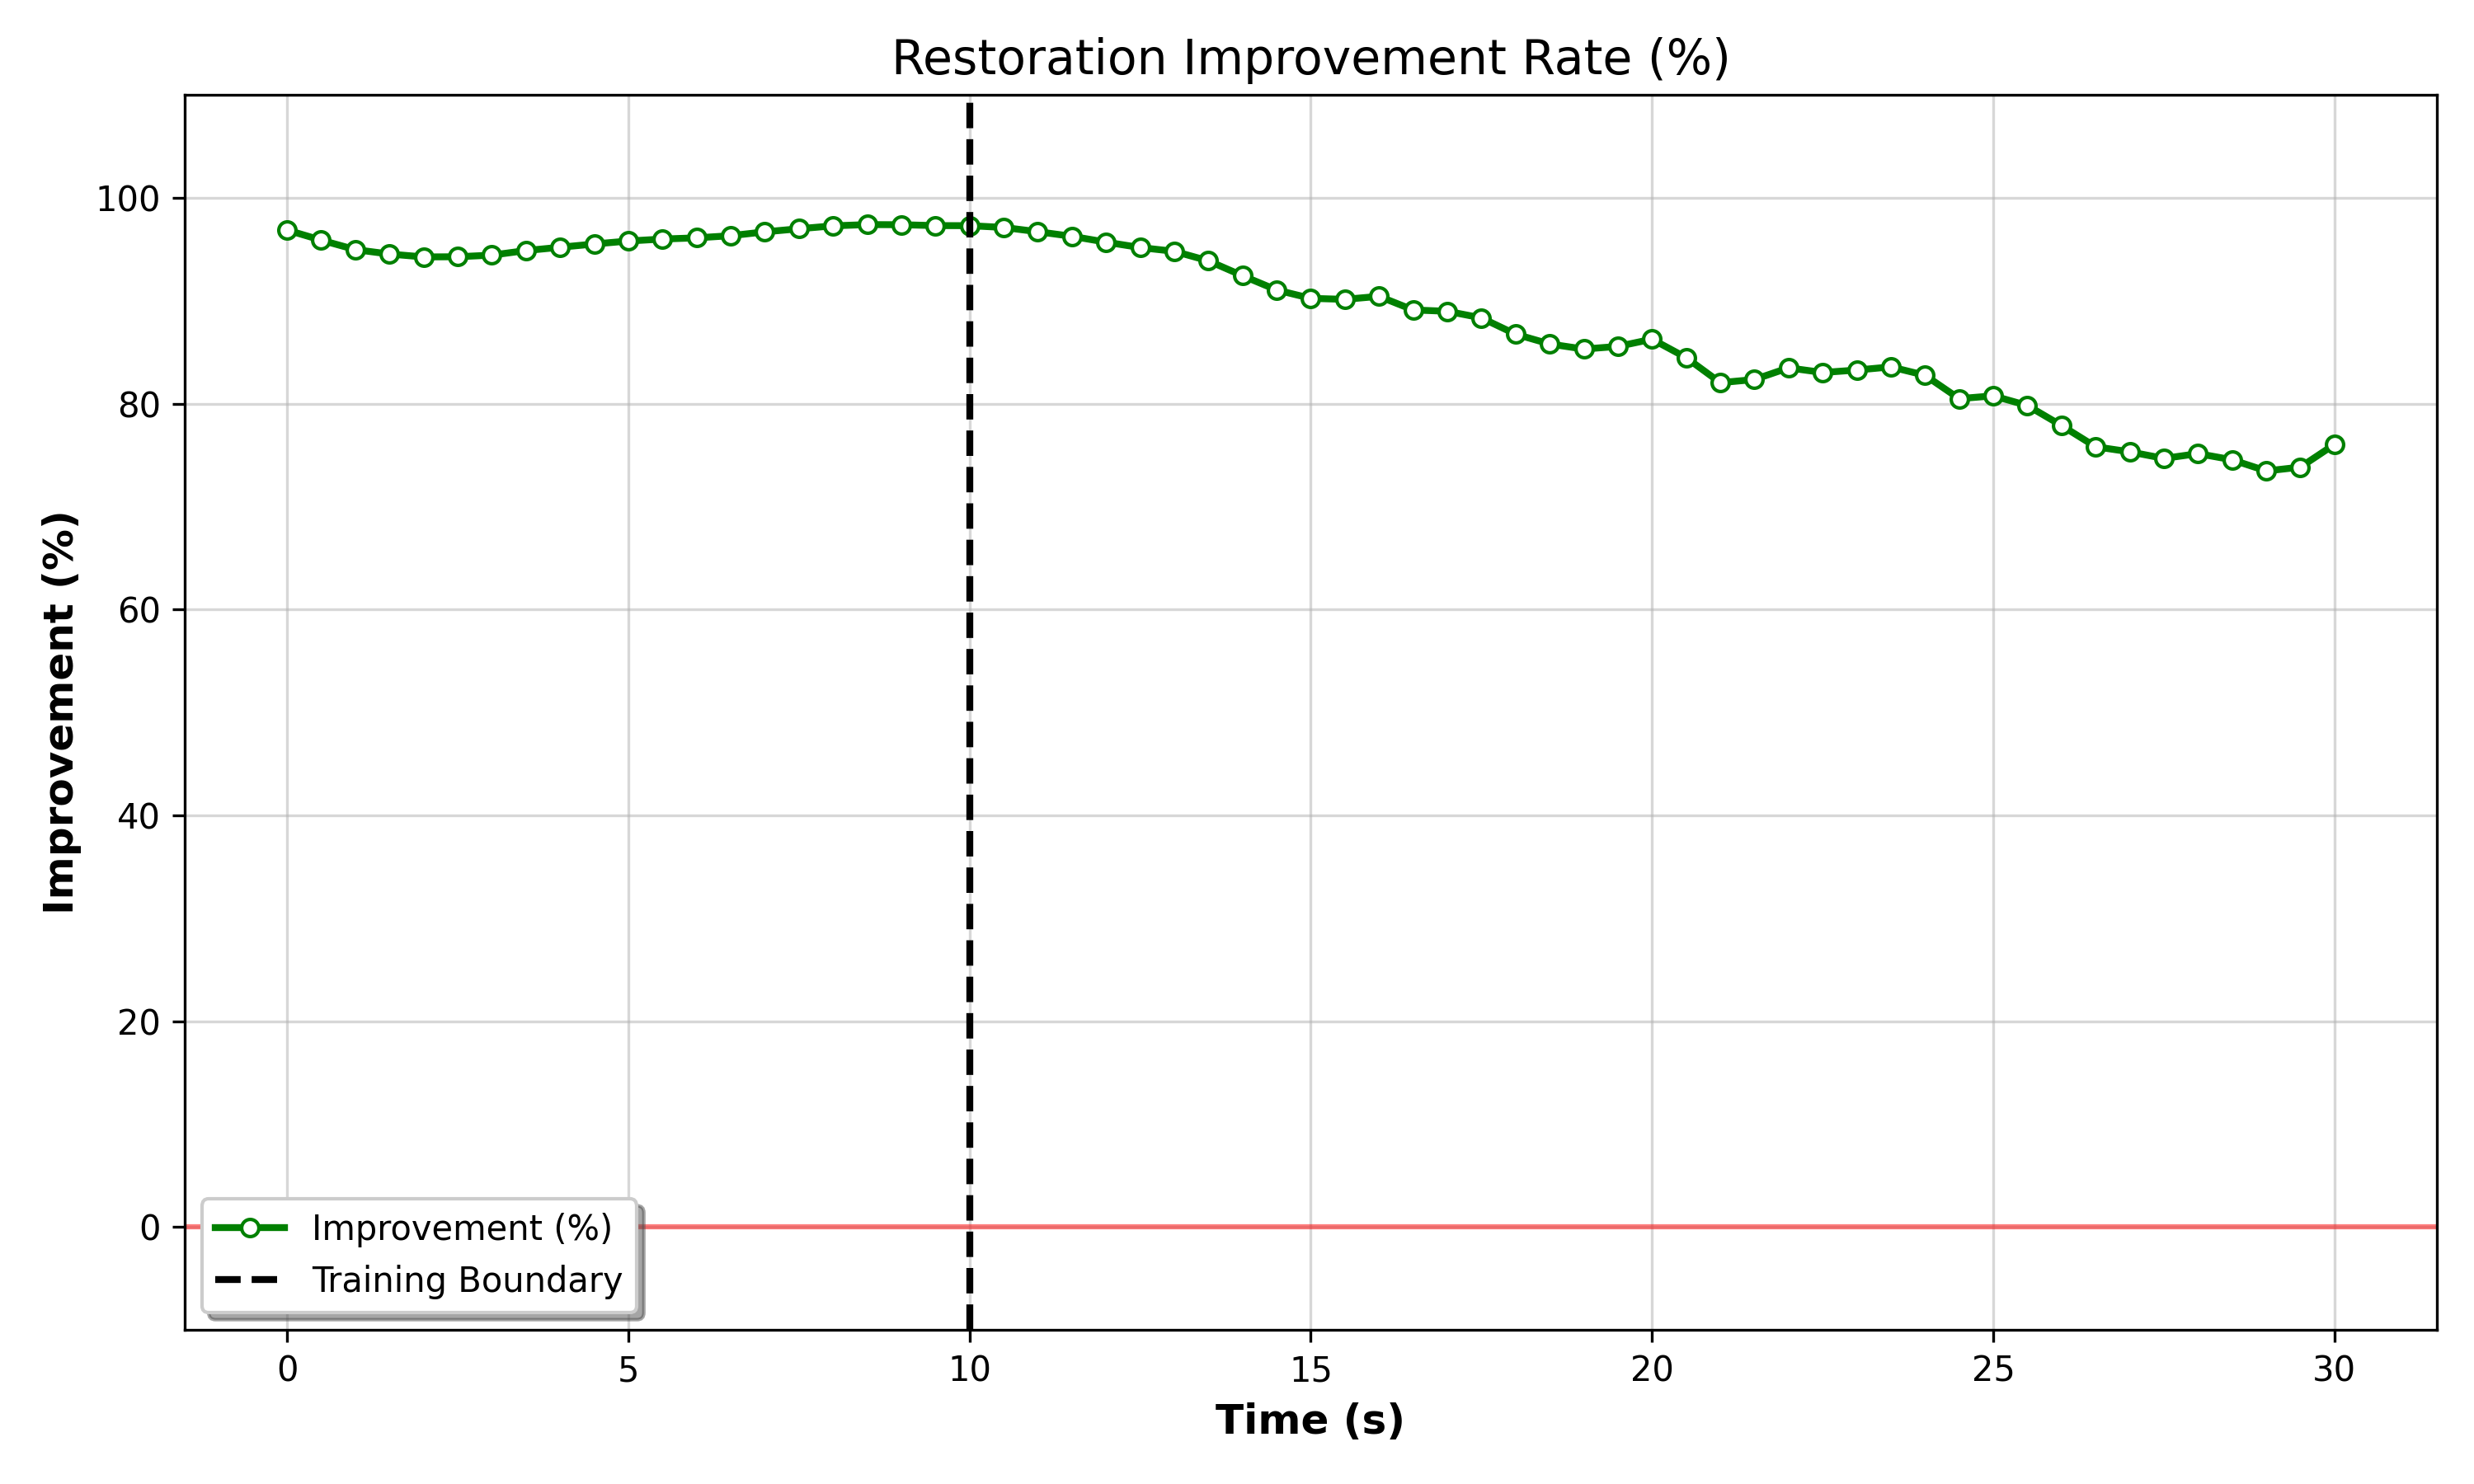

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# 1. 저장 경로 설정
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_individual_performance_graphs():
    print("Calculating performance metrics over time (0s ~ 30s)...")

    # --- 데이터 계산 단계 ---
    t_eval = np.linspace(0, 30, 61) # 0.5초 간격
    mse_lf_list = []
    mse_pinn_list = []
    improvement_list = []

    model.eval()
    with torch.no_grad():
        for t_val in t_eval:
            # Data Generation
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            # Metric Calculation
            mse_lf = np.mean((u_l - u_h)**2)
            mse_pinn = np.mean((u_pred - u_h)**2)

            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            mse_lf_list.append(mse_lf)
            mse_pinn_list.append(mse_pinn)
            improvement_list.append(imp)

    print("Data calculation complete. Generatig graphs...")

    # --- 그래프 1: MSE Comparison (Log Scale) ---
    plt.figure(figsize=(10, 6))

    # Plot Lines
    plt.plot(t_eval, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.7, linewidth=1.5)
    plt.plot(t_eval, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)

    # Boundary Line (t=10)
    plt.axvline(x=10, color='k', linestyle='--', linewidth=2, label='Training Boundary (t=10)')

    # Background Colors (Zones)
    plt.axvspan(0, 10, color='green', alpha=0.05, label='Training Zone')
    plt.axvspan(10, 30, color='orange', alpha=0.05, label='Extrapolation Zone')

    # Settings
    plt.yscale('log') # Log Scale
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('MSE (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('MSE Comparison: Input vs Output', fontsize=14)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.tight_layout()

    # Save
    path1 = os.path.join(save_dir, "mse_log_scale.png")
    plt.savefig(path1, dpi=300)
    plt.close() # 닫아야 다음 그래프에 영향 없음
    print(f"1. MSE Graph saved to: {path1}")

    # --- 그래프 2: Improvement Rate ---
    plt.figure(figsize=(10, 6))

    # Plot Line
    plt.plot(t_eval, improvement_list, 'g-o', label='Improvement (%)',
             linewidth=2, markersize=5, markerfacecolor='white')

    # Boundary Line (t=10)
    plt.axvline(x=10, color='k', linestyle='--', linewidth=2, label='Training Boundary')

    # Zero Line (Red)
    plt.axhline(y=0, color='r', linestyle='-', linewidth=1.5, alpha=0.5)

    # Settings
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('Improvement (%)', fontsize=12, fontweight='bold')
    plt.title('Restoration Improvement Rate (%)', fontsize=14)
    plt.legend(loc='lower left', frameon=True, shadow=True)
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.ylim(min(min(improvement_list)-5, -10), 110) # Y축 여유 있게
    plt.tight_layout()

    # Save
    path2 = os.path.join(save_dir, "improvement_trend.png")
    plt.savefig(path2, dpi=300)
    plt.close()
    print(f"2. Improvement Graph saved to: {path2}")

    # 화면에 보여주기 (선택 사항)
    from IPython.display import display, Image
    display(Image(filename=path1))
    display(Image(filename=path2))

# 실행
save_individual_performance_graphs()

Calculating performance metrics over time (0s ~ 30s)...
Data calculation complete. Generatig graphs...
1. MSE Graph saved to: results/mse_log_scale.png
2. Improvement Graph saved to: results/improvement_trend.png


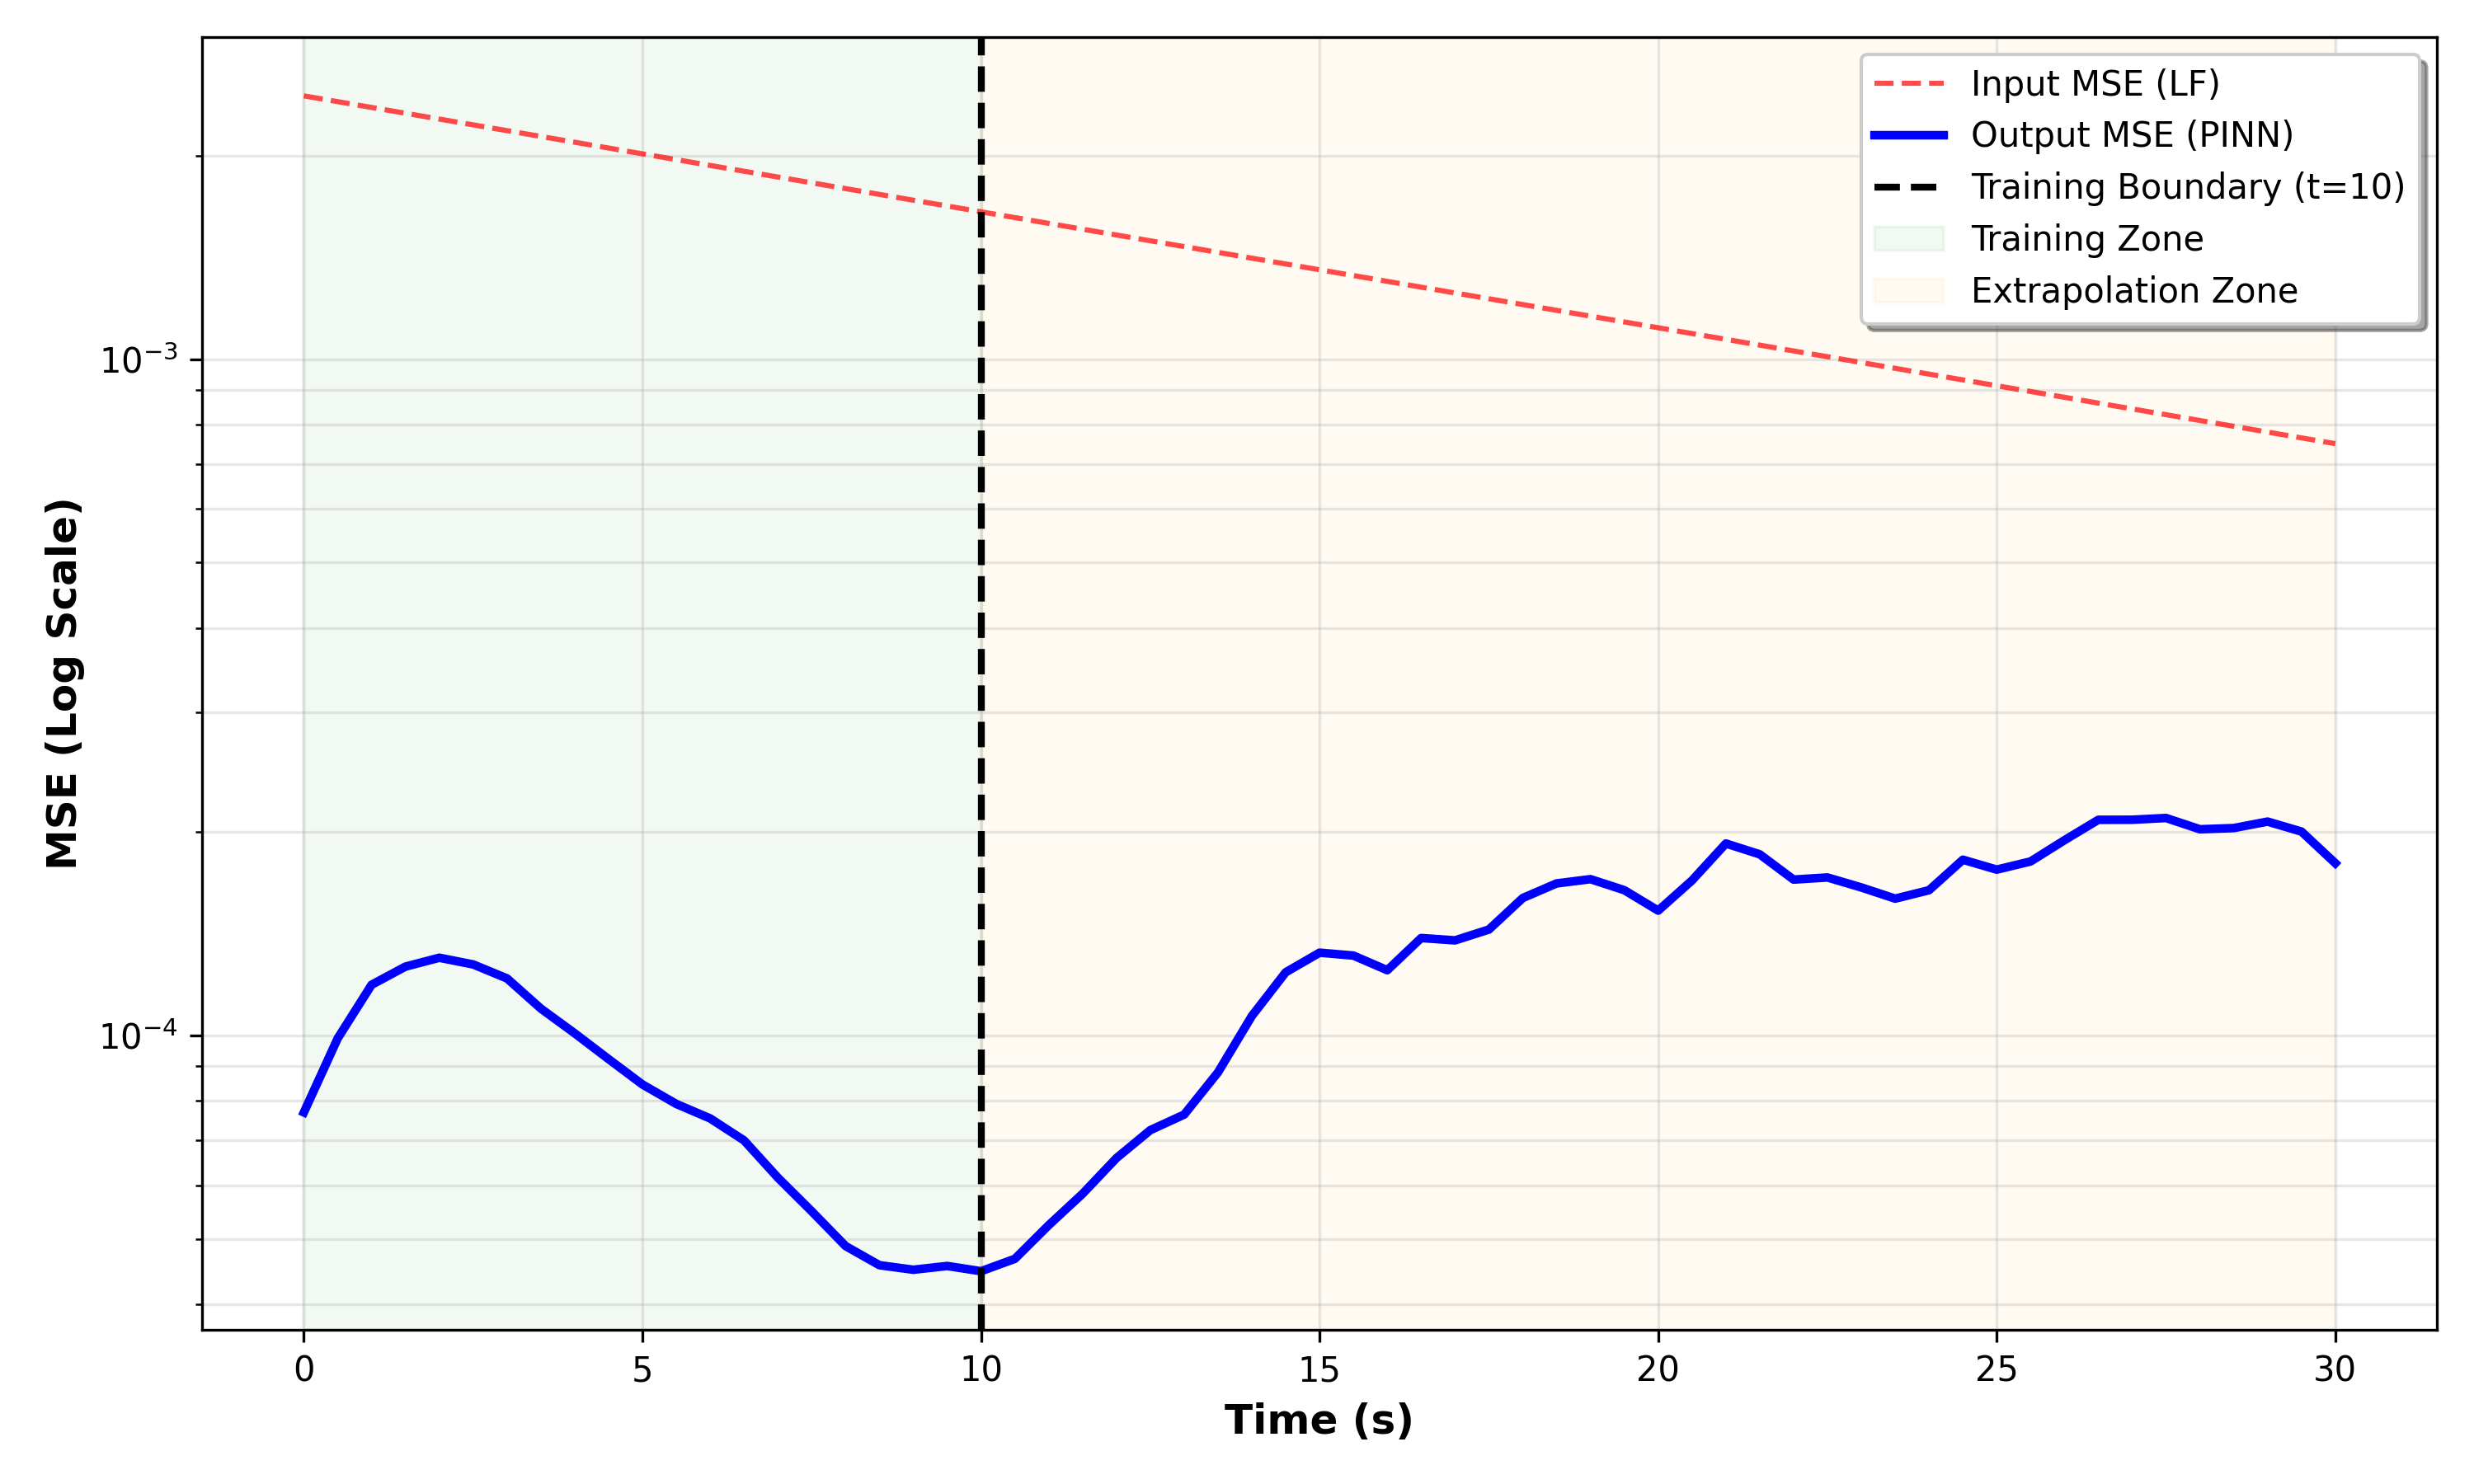

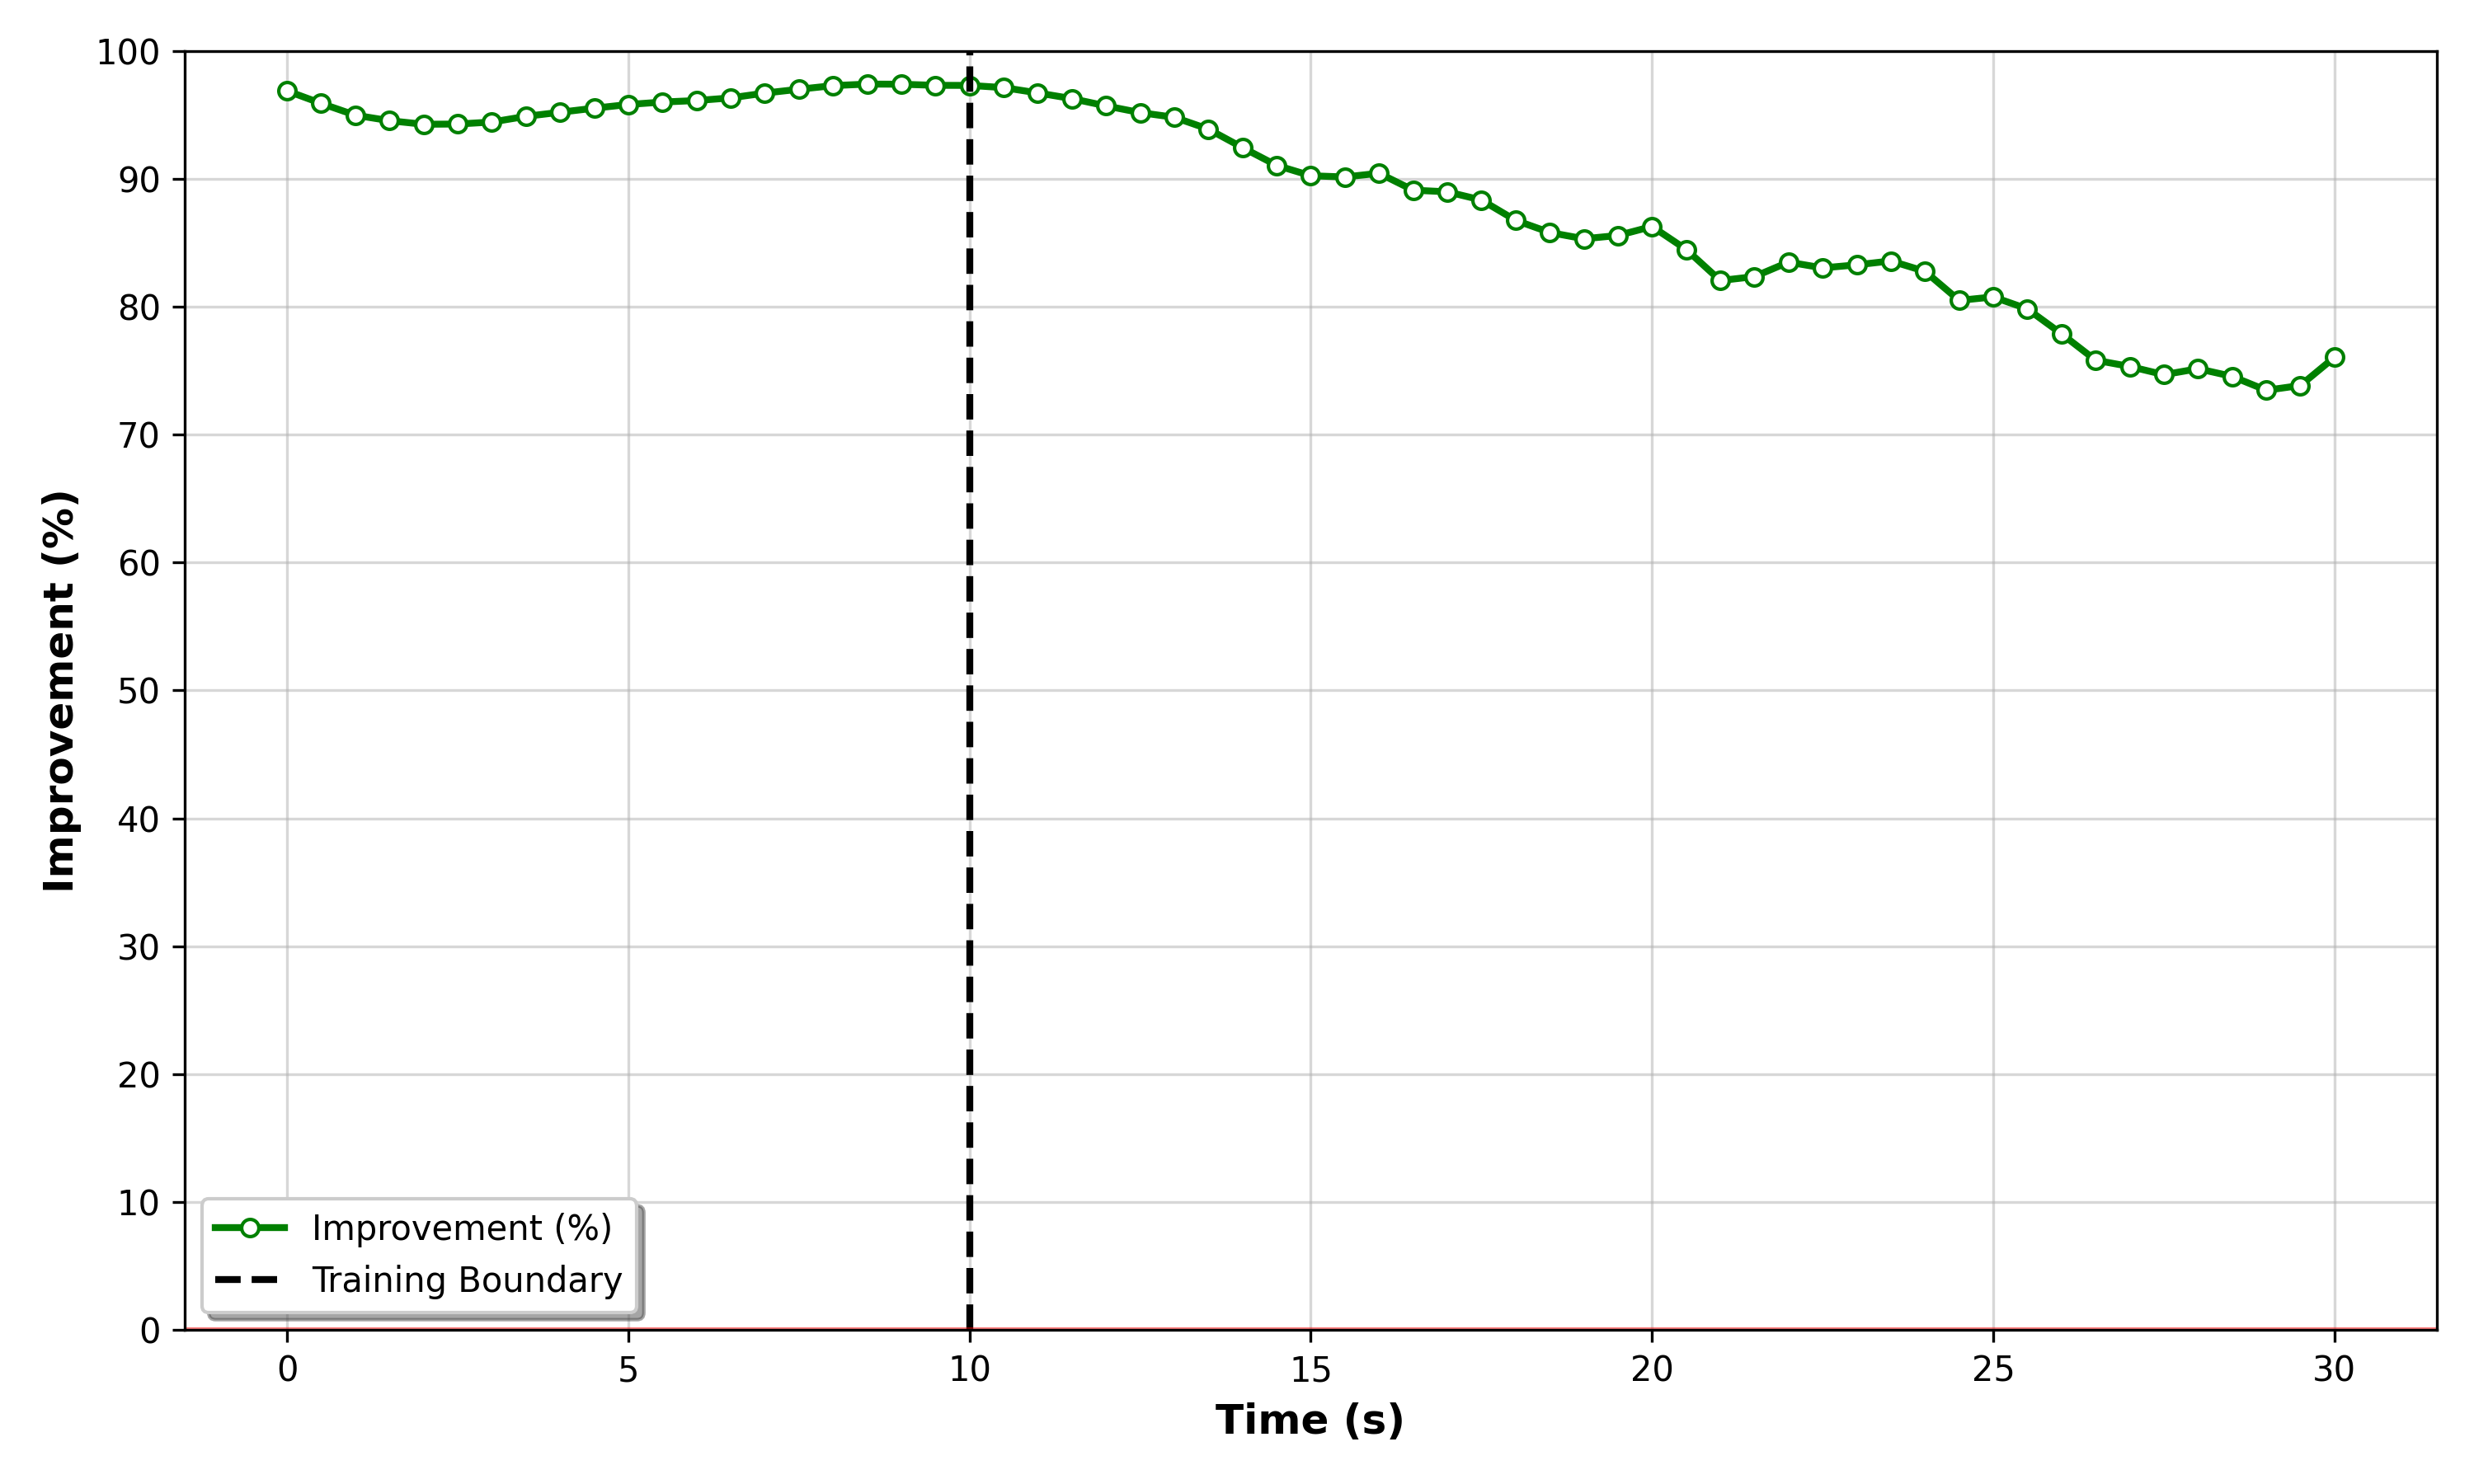

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

# 1. 저장 경로 설정
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_individual_performance_graphs():
    print("Calculating performance metrics over time (0s ~ 30s)...")

    # --- 데이터 계산 단계 ---
    t_eval = np.linspace(0, 30, 61) # 0.5초 간격
    mse_lf_list = []
    mse_pinn_list = []
    improvement_list = []

    model.eval()
    with torch.no_grad():
        for t_val in t_eval:
            # Data Generation
            X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

            x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
            t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)

            u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_lf_in = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_lf_in = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

            out = model(x_in, y_in, t_in, u_lf_in, v_lf_in, p_lf_in)
            u_pred = out[:, 0].cpu().numpy().reshape(GRID, GRID)

            # Metric Calculation
            mse_lf = np.mean((u_l - u_h)**2)
            mse_pinn = np.mean((u_pred - u_h)**2)

            if mse_lf > 1e-15:
                imp = (mse_lf - mse_pinn) / mse_lf * 100
            else:
                imp = 0.0

            mse_lf_list.append(mse_lf)
            mse_pinn_list.append(mse_pinn)
            improvement_list.append(imp)

    print("Data calculation complete. Generatig graphs...")

    # --- 그래프 1: MSE Comparison (Log Scale) ---
    plt.figure(figsize=(10, 6))

    # Plot Lines
    plt.plot(t_eval, mse_lf_list, 'r--', label='Input MSE (LF)', alpha=0.7, linewidth=1.5)
    plt.plot(t_eval, mse_pinn_list, 'b-', label='Output MSE (PINN)', linewidth=2.5)

    # Boundary Line (t=10)
    plt.axvline(x=10, color='k', linestyle='--', linewidth=2, label='Training Boundary (t=10)')

    # Background Colors (Zones)
    plt.axvspan(0, 10, color='green', alpha=0.05, label='Training Zone')
    plt.axvspan(10, 30, color='orange', alpha=0.05, label='Extrapolation Zone')

    # Settings
    plt.yscale('log') # Log Scale
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('MSE (Log Scale)', fontsize=12, fontweight='bold')
    plt.title('', fontsize=14)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.tight_layout()

    # Save
    path1 = os.path.join(save_dir, "mse_log_scale.png")
    plt.savefig(path1, dpi=300)
    plt.close()
    print(f"1. MSE Graph saved to: {path1}")

    # --- 그래프 2: Improvement Rate ---
    plt.figure(figsize=(10, 6))

    # Plot Line
    plt.plot(t_eval, improvement_list, 'g-o', label='Improvement (%)',
             linewidth=2, markersize=5, markerfacecolor='white')

    # Boundary Line (t=10)
    plt.axvline(x=10, color='k', linestyle='--', linewidth=2, label='Training Boundary')

    # Zero Line (Red)
    plt.axhline(y=0, color='r', linestyle='-', linewidth=1.5, alpha=0.5)

    # Settings
    plt.xlabel('Time (s)', fontsize=12, fontweight='bold')
    plt.ylabel('Improvement (%)', fontsize=12, fontweight='bold')
    plt.title('', fontsize=14)

    # [수정 부분] Y축 범위 및 10단위 간격 설정
    plt.ylim(0, 100)
    plt.yticks(np.arange(0, 101, 10)) # -10부터 110까지 10 간격

    plt.legend(loc='lower left', frameon=True, shadow=True)
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.tight_layout()

    # Save
    path2 = os.path.join(save_dir, "improvement_trend.png")
    plt.savefig(path2, dpi=300)
    plt.close()
    print(f"2. Improvement Graph saved to: {path2}")

    # 화면에 보여주기
    from IPython.display import display, Image
    display(Image(filename=path1))
    display(Image(filename=path2))

# 실행
save_individual_performance_graphs()

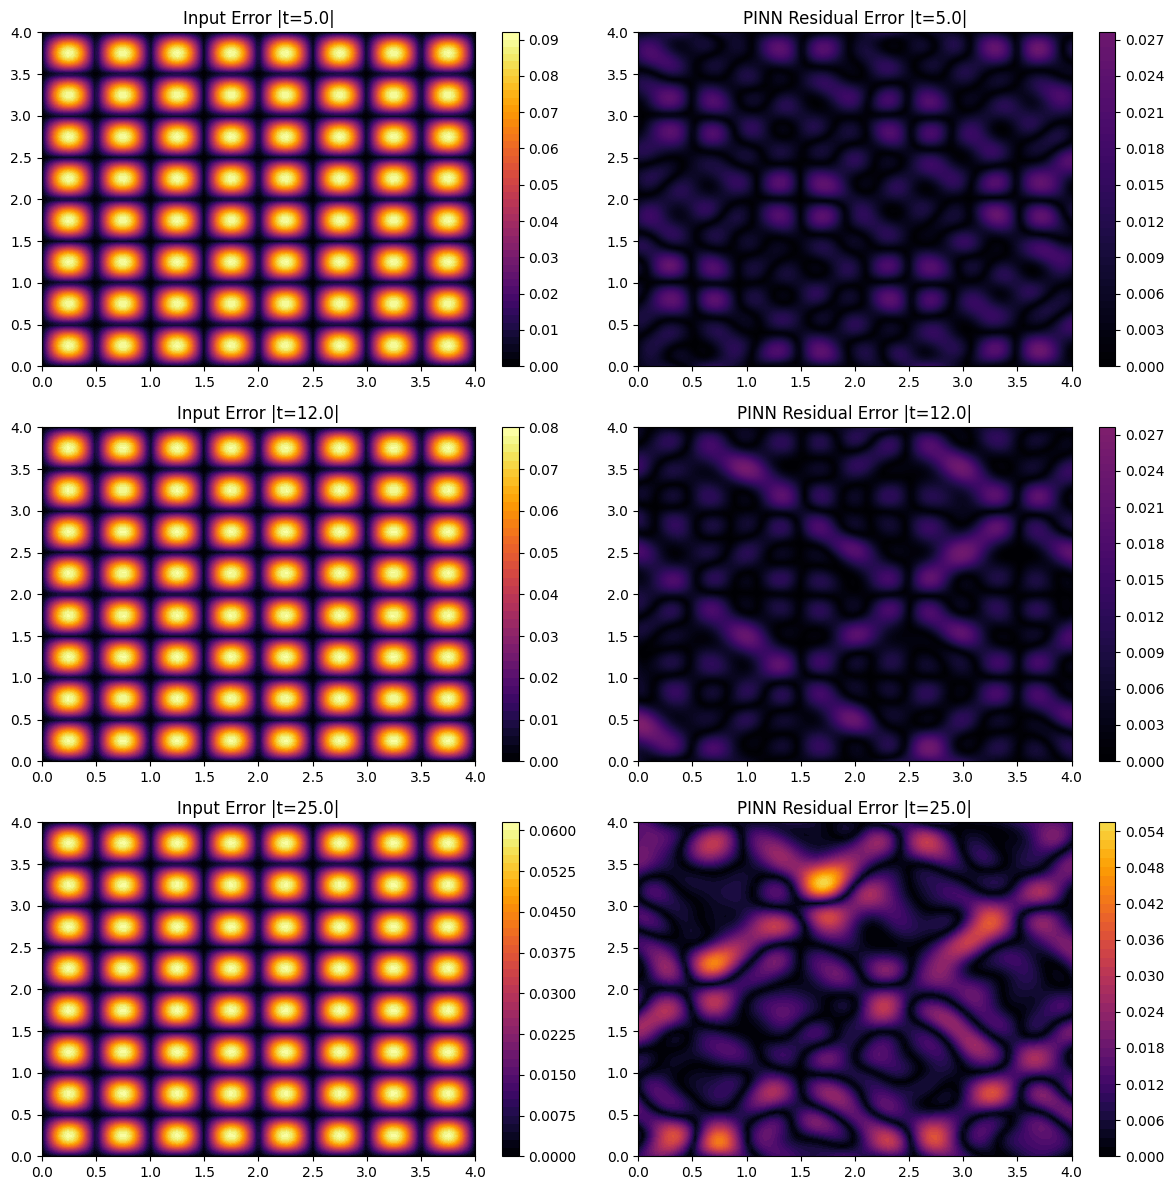

In [ ]:
def plot_error_maps(times=[5.0, 12.0, 25.0]):
    fig, axes = plt.subplots(len(times), 2, figsize=(12, 4 * len(times)))

    for i, t_val in enumerate(times):
        # 데이터 획득
        X_g, Y_g, u_l, _, _, u_h, _, _ = generator.get_data_at_t(GRID, GRID, t_val)

        # 모델 예측
        x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)
        u_lf_in = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        v_lf_in = torch.tensor(np.zeros_like(u_l.flatten()), dtype=torch.float32).view(-1, 1).to(device) # 간소화
        p_lf_in = torch.tensor(np.zeros_like(u_l.flatten()), dtype=torch.float32).view(-1, 1).to(device)

        model.eval()
        with torch.no_grad():
            # 실제 코드에서는 v_l, p_l도 넣어주어야 함 (위 셀의 변수 사용)
            _, _, u_l_raw, v_l_raw, p_l_raw, _, _, _ = generator.get_data_at_t(GRID, GRID, t_val)
            u_l_t = torch.tensor(u_l_raw.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            v_l_t = torch.tensor(v_l_raw.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            p_l_t = torch.tensor(p_l_raw.flatten(), dtype=torch.float32).view(-1, 1).to(device)
            u_pred = model(x_in, y_in, t_in, u_l_t, v_l_t, p_l_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

        # 오차 계산
        error_input = np.abs(u_l - u_h)   # 입력(LF)의 오차
        error_pinn = np.abs(u_pred - u_h) # 모델(PINN)의 오차

        # 시각화 (동일한 컬러바 범위를 위해 vmin, vmax 설정)
        vmax = max(error_input.max(), error_pinn.max())

        im1 = axes[i, 0].contourf(X_g, Y_g, error_input, 50, cmap='inferno', vmin=0, vmax=vmax)
        axes[i, 0].set_title(f"Input Error |t={t_val}|")
        plt.colorbar(im1, ax=axes[i, 0])

        im2 = axes[i, 1].contourf(X_g, Y_g, error_pinn, 50, cmap='inferno', vmin=0, vmax=vmax)
        axes[i, 1].set_title(f"PINN Residual Error |t={t_val}|")
        plt.colorbar(im2, ax=axes[i, 1])

    plt.tight_layout()
    plt.savefig("results/error_distribution_maps.png", dpi=200)
    plt.show()

plot_error_maps()

In [ ]:
import os
print("파일 목록 확인:", os.listdir('results'))
print("GIF 존재 여부:", os.path.exists('results/restoration_process.gif'))

파일 목록 확인: ['result_t_9.50.png', 'result_t_1.25.png', 'improvement_trend.png', 'restoration_process.gif', 'result_t_7.30.png', 'result_t_20.00.png', 'result_t_11.50.png', 'result_t_13.00.png', 'mse_log_scale.png', 'error_distribution_maps.png', 'result_t_2.50.png', 'improvement_trend_broken.png', 'result_t_25.00.png', 'result_t_15.00.png', 'result_t_30.00.png']
GIF 존재 여부: True


In [ ]:
from IPython.display import FileLink
import shutil

# 만약 zip 파일에 포함이 안 된 거라면 다시 압축
shutil.make_archive('results_final', 'zip', 'results')

print("아래 링크를 클릭해서 전체 결과(GIF 포함)를 다운로드하세요:")
FileLink('results_final.zip')

아래 링크를 클릭해서 전체 결과(GIF 포함)를 다운로드하세요:


/kaggle/working/results_final.zip

In [ ]:
import os
import shutil
from IPython.display import FileLink, display

# 1. 특정 파일 존재 여부 재확인
error_map_path = 'results/error_distribution_maps.png'
gif_path = 'results/restoration_process.gif'

print("=== 파일 존재 여부 점검 ===")
for path in [error_map_path, gif_path]:
    if os.path.exists(path):
        print(f"✅ [존재함] {path}")
    else:
        print(f"❌ [미발견] {path} - 해당 셀이 성공적으로 실행되었는지 확인이 필요합니다.")

# 2. 개별 파일 다운로드 링크 생성 (존재하는 경우만)
print("\n=== 개별 파일 다운로드 링크 ===")
if os.path.exists(error_map_path):
    display(FileLink(error_map_path))
if os.path.exists(gif_path):
    display(FileLink(gif_path))

# 3. 전체 results 폴더를 다시 압축 (강제 새로고침 효과)
# 기존 archive가 있다면 이름을 바꿔서 새로 생성합니다.
zip_name = 'final_all_results'
shutil.make_archive(zip_name, 'zip', 'results')

print(f"\n=== 전체 결과 압축파일 ({zip_name}.zip) ===")
display(FileLink(f'{zip_name}.zip'))

=== 파일 존재 여부 점검 ===
✅ [존재함] results/error_distribution_maps.png
✅ [존재함] results/restoration_process.gif

=== 개별 파일 다운로드 링크 ===


/kaggle/working/results/error_distribution_maps.png

/kaggle/working/results/restoration_process.gif


=== 전체 결과 압축파일 (final_all_results.zip) ===


/kaggle/working/final_all_results.zip

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_animation():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    t_frames = np.linspace(0, 30, 60) # 30초 동안 60프레임

    def update(t_val):
        ax1.clear(); ax2.clear()
        X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

        # 모델 예측
        x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)
        u_l_t = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        v_l_t = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        p_l_t = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

        with torch.no_grad():
            u_pred = model(x_in, y_in, t_in, u_l_t, v_l_t, p_l_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

        # 그리기
        cf1 = ax1.contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r')
        ax1.set_title(f"Input LF (Noisy) | t={t_val:.1f}s")
        cf2 = ax2.contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r')
        ax2.set_title(f"PINN Restored HF | t={t_val:.1f}s")

    print("Creating animation... (this may take a minute)")
    ani = FuncAnimation(fig, update, frames=t_frames, interval=100)
    ani.save("results/restoration_process.gif", writer=PillowWriter(fps=10))
    plt.close()
    print("Animation saved as results/restoration_process.gif")

create_animation()

Creating animation... (this may take a minute)
Animation saved as results/restoration_process.gif


In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

def create_performance_table():
    test_times = [1.25, 5.0, 10.0, 13.0, 15.0, 20.0, 25.0, 30.0]
    results = []

    for t_val in test_times:
        X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

        x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)
        u_l_t = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        v_l_t = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        p_l_t = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

        with torch.no_grad():
            u_pred = model(x_in, y_in, t_in, u_l_t, v_l_t, p_l_t)[:, 0].cpu().numpy().flatten()

        u_true = u_h.flatten()

        # 지표 계산
        mse = np.mean((u_true - u_pred)**2)
        r2 = r2_score(u_true, u_pred)
        l2_rel = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)

        zone = "Training" if t_val <= 10 else ("Physics-Guided" if t_val <= 13 else "Pure Extrapol.")

        results.append({
            "Time (s)": t_val,
            "Zone": zone,
            "MSE": f"{mse:.2e}",
            "R2 Score": f"{r2:.4f}",
            "Rel. L2 Error": f"{l2_rel:.4f}"
        })

    df = pd.DataFrame(results)
    print("\n=== Performance Summary Table ===")
    display(df) # 코랩/캐글에서 예쁘게 출력
    df.to_csv("results/performance_table.csv", index=False)
    return df

performance_df = create_performance_table()


=== Performance Summary Table ===


,Time (s),Zone,MSE,R2 Score,Rel. L2 Error
0,1.25,Training,1.23e-04,0.9995,0.0227
1,5.00,Training,8.46e-05,0.9996,0.0203
2,10.00,Training,4.48e-05,0.9997,0.0163
3,13.00,Physics-Guided,7.63e-05,0.9995,0.0226
4,15.00,Pure Extrapol.,1.32e-04,0.9990,0.0310
5,20.00,Pure Extrapol.,1.53e-04,0.9987,0.0367
6,25.00,Pure Extrapol.,1.76e-04,0.9981,0.0434
7,30.00,Pure Extrapol.,1.80e-04,0.9977,0.0485


In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
import os

def create_3panel_animation():
    # 1. 그래프 설정 (1행 3열)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    t_frames = np.linspace(0, 30, 60) # 0~30초 사이 60프레임 (0.5초 간격)

    save_path = "results/restoration_process_3panels.gif"

    def update(t_val):
        # 화면 초기화
        for ax in axes:
            ax.clear()

        # 해당 시간 데이터 생성
        X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

        # 모델 예측을 위한 텐서 준비
        x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)
        u_l_t = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        v_l_t = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        p_l_t = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

        # 모델 예측
        model.eval()
        with torch.no_grad():
            u_pred = model(x_in, y_in, t_in, u_l_t, v_l_t, p_l_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

        # 공통 컬러바 범위를 위해 vmin/vmax 설정 (HF 기준으로 설정)
        v_min, v_max = u_h.min(), u_h.max()

        # 1. 왼쪽: Input LF (Noisy)
        axes[0].contourf(X_g, Y_g, u_l, 50, cmap='RdBu_r', vmin=v_min, vmax=v_max)
        axes[0].set_title(f"Input LF (Noisy)\nTime: {t_val:.1f}s")

        # 2. 가운데: PINN Prediction
        axes[1].contourf(X_g, Y_g, u_pred, 50, cmap='RdBu_r', vmin=v_min, vmax=v_max)
        axes[1].set_title(f"PINN Corrected\n(Physics-Informed)")

        # 3. 오른쪽: Ground Truth HF
        axes[2].contourf(X_g, Y_g, u_h, 50, cmap='RdBu_r', vmin=v_min, vmax=v_max)
        axes[2].set_title(f"Ground Truth HF\n(Clean Solution)")

        plt.tight_layout()

    print("3-Panel 애니메이션 생성 중... (약 1~2분 소요)")
    ani = FuncAnimation(fig, update, frames=t_frames)

    # fps=10: 10프레임당 1초 (총 6초 분량의 영상)
    writer = PillowWriter(fps=10)
    ani.save(save_path, writer=writer)
    plt.close(fig)

    print(f"✅ 애니메이션 저장 완료: {save_path}")

# 실행
create_3panel_animation()

3-Panel 애니메이션 생성 중... (약 1~2분 소요)
✅ 애니메이션 저장 완료: results/restoration_process_3panels.gif


In [ ]:
from IPython.display import FileLink
display(FileLink('results/restoration_process_3panels.gif'))

/kaggle/working/results/restoration_process_3panels.gif

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import os

def create_high_quality_animation():
    # 1. 그래프 설정 (DPI를 150 이상으로 높여 선명하게 설정)
    plt.rcParams['figure.dpi'] = 150
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    t_frames = np.linspace(0, 30, 90) # 프레임을 90개로 늘려 더 부드럽게 (10초 분량)

    save_path_gif = "results/restoration_high_res.gif"
    save_path_mp4 = "results/restoration_high_res.mp4"

    # 전역 최대/최소값 미리 계산 (플리커링 방지)
    _, _, _, _, _, u_h_start, _, _ = generator.get_data_at_t(GRID, GRID, 0)
    v_max, v_min = u_h_start.max(), u_h_start.min()

    def update(t_val):
        for ax in axes: ax.clear()

        X_g, Y_g, u_l, v_l, p_l, u_h, v_h, p_h = generator.get_data_at_t(GRID, GRID, t_val)

        # 모델 예측
        x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
        t_in = torch.tensor(np.full(x_in.shape, t_val/T_scale), dtype=torch.float32).view(-1, 1).to(device)
        u_l_t = torch.tensor(u_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        v_l_t = torch.tensor(v_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        p_l_t = torch.tensor(p_l.flatten(), dtype=torch.float32).view(-1, 1).to(device)

        model.eval()
        with torch.no_grad():
            u_pred = model(x_in, y_in, t_in, u_l_t, v_l_t, p_l_t)[:, 0].cpu().numpy().reshape(GRID, GRID)

        # 렌더링 (shading='gouraud'를 써서 픽셀 사이를 아주 매끄럽게 보간)
        # 100단계의 contourf를 사용하여 부드러운 그라데이션 구현
        levels = np.linspace(v_min, v_max, 100)

        im0 = axes[0].contourf(X_g, Y_g, u_l, levels=levels, cmap='RdBu_r', extend='both')
        axes[0].set_title(f"Input LF (Noisy)\nTime: {t_val:.1f}s", fontsize=15, fontweight='bold')

        im1 = axes[1].contourf(X_g, Y_g, u_pred, levels=levels, cmap='RdBu_r', extend='both')
        axes[1].set_title(f"PINN Corrected\n(Physics-Informed)", fontsize=15, fontweight='bold', color='blue')

        im2 = axes[2].contourf(X_g, Y_g, u_h, levels=levels, cmap='RdBu_r', extend='both')
        axes[2].set_title(f"Ground Truth HF\n(Clean Solution)", fontsize=15, fontweight='bold')

        for ax in axes:
            ax.set_xticks([]); ax.set_yticks([]) # 축 눈금 제거해서 깔끔하게

        plt.tight_layout()

    print("🚀 고화질 애니메이션 렌더링 시작... (시간이 다소 소요됩니다)")
    ani = FuncAnimation(fig, update, frames=t_frames)

    # --- 옵션 1: 고화질 GIF 저장 ---
    # dpi를 높이고 품질(optimize) 설정 추가
    writer_gif = PillowWriter(fps=12)
    ani.save(save_path_gif, writer=writer_gif)
    print(f"✅ GIF 저장 완료: {save_path_gif}")

    # --- 옵션 2: 초고화질 MP4 저장 (H.264 코덱 사용, 색상 표현 완벽) ---
    try:
        writer_mp4 = FFMpegWriter(fps=12, bitrate=5000) # 고비트레이트 설정
        ani.save(save_path_mp4, writer=writer_mp4)
        print(f"✅ MP4 저장 완료: {save_path_mp4}")
    except:
        print("⚠️ FFMpeg가 설치되어 있지 않아 MP4 저장은 건너뜁니다.")

    plt.close(fig)

# 실행
create_high_quality_animation()

🚀 고화질 애니메이션 렌더링 시작... (시간이 다소 소요됩니다)
✅ GIF 저장 완료: results/restoration_high_res.gif
✅ MP4 저장 완료: results/restoration_high_res.mp4


In [ ]:
from IPython.display import FileLink, display

# GIF와 MP4 모두 링크 생성
display(FileLink('results/restoration_high_res.gif'))
display(FileLink('results/restoration_high_res.mp4'))

/kaggle/working/results/restoration_high_res.gif

/kaggle/working/results/restoration_high_res.mp4